In [1]:

import json
from datasets import Dataset, Image

#### 1. Create a dataset from a dictionary

Use Dataset.from_dict() to build a Hugging Face Dataset object from a Python dictionary, where each key represents a column (here, "image" and "text"), and each value is a list of corresponding entries.

Convert the "image" column to the special Image() type using cast_column(), enabling the dataset to handle image files as PIL objects

In [2]:
dataset = Dataset.from_dict({"image": ["images/sandy_a.png", "images/sandy_b.png", "images/silty_clay_c.png"], 
                        "text": ["sandy soil sample", "sandy soil sample", "a silty clay soil sample"]})
dataset = dataset.cast_column("image", Image())
dataset.save_to_disk("dataset.ds")

Saving the dataset (0/1 shards):   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
## Use the following command to save the dataset to your local computer.
# dataset = dataset.load_from_disk("dataset.ds")

In [4]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 3
})

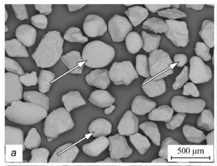

In [5]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [6]:
example["text"]

'sandy soil sample'

#### 2. Define a custom PyTorch dataset class

Create an ImageCaptioningDataset class inheriting from torch.utils.data.Dataset. This class wraps the Hugging Face dataset and applies a processor to each item for model compatibility.

In [7]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

#### 3. Load a pre-trained processor

In [8]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### 4. Wrap the dataset with the processor

Create an instance of ImageCaptioningDataset, passing in the dataset and processor, to prepare data for training.

In [30]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [31]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


#### 5. Set up a DataLoader

In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

Inspect a batch

In [33]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [ ]:
# Here, we are just showing how encoded text can be decoded.
processor.decode(batch["input_ids"][0])

'[CLS] sandy soil sample [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

#### 6. Load a pre-trained model

In [36]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [37]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0610, grad_fn=<NllLossBackward0>)

#### 7. Train the model

In [39]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss: 12.196807861328125
Loss: 10.719894409179688
Epoch: 1
Loss: 10.137663841247559
Loss: 9.871201515197754
Epoch: 2
Loss: 9.636015892028809
Loss: 9.416107177734375
Epoch: 3
Loss: 9.211209297180176
Loss: 9.02257251739502
Epoch: 4
Loss: 8.868475914001465
Loss: 8.724950790405273
Epoch: 5
Loss: 8.595325469970703
Loss: 8.47923755645752
Epoch: 6
Loss: 8.358694076538086
Loss: 8.24553394317627
Epoch: 7
Loss: 8.130643844604492
Loss: 8.030829429626465
Epoch: 8
Loss: 7.921918869018555
Loss: 7.823979377746582
Epoch: 9
Loss: 7.730930328369141
Loss: 7.61496114730835
Epoch: 10
Loss: 7.520208358764648
Loss: 7.427955627441406
Epoch: 11
Loss: 7.3184614181518555
Loss: 7.227565765380859
Epoch: 12
Loss: 7.115767002105713
Loss: 7.024778842926025
Epoch: 13
Loss: 6.926509380340576
Loss: 6.798075199127197
Epoch: 14
Loss: 6.706971168518066
Loss: 6.611051559448242
Epoch: 15
Loss: 6.51210355758667
Loss: 6.379049777984619
Epoch: 16
Loss: 6.286809921264648
Loss: 6.187399864196777
Epoch: 17
Loss: 6.0758018

#### 8. Generate a caption

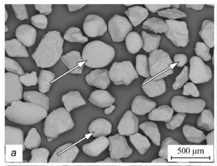

In [40]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [41]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

soil
